In [2]:
%cd ..

/Users/juansegundohevia/Documents/repos/TexTract


In [3]:
import pix2tex.cli as cli
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd 
import pickle as pkl
from pix2tex.dataset.dataset import Im2LatexDataset
import yaml
from munch import Munch

/Users/juansegundohevia/anaconda3/envs/pix2text/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Replicate eval.py logic

In [28]:
import pix2tex.utils as p2t_utils
import pix2tex.models as p2t_models

CONFIG_PATH = "pix2tex/model/settings/config.yaml"
BATCHSIZE = 1
TEMPERATURE = .9
CHECKPOINT_PATH = "hw_checkpoints/handwritten_training/handwritten_training_e19_step63.pth"
DEVICE = "cpu"
DATA_PATH = "pix2tex/dataset/handwritten/test.pkl"

with open(CONFIG_PATH, "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

args = p2t_utils.parse_args(Munch(config))

args.testbatchsize = BATCHSIZE
args.wandb = False
args.temperature = TEMPERATURE

model = p2t_models.get_model(args)
model.load_state_dict(torch.load(CHECKPOINT_PATH, DEVICE))

dataset = Im2LatexDataset(pad=True).load(DATA_PATH)
valargs = args.copy()
valargs.update(batchsize=args.testbatchsize, keep_smaller_batches=True, test=True)
dataset.update(**valargs)

In [45]:
from collections import defaultdict

def evaluate(model, dataset: Im2LatexDataset, args: Munch, num_batches: int = None, name: str = 'test'):
    """evaluates the model. Returns bleu score on the dataset

    Args:
        model (torch.nn.Module): the model
        dataset (Im2LatexDataset): test dataset
        args (Munch): arguments
        num_batches (int): How many batches to evaluate on. Defaults to None (all batches).
        name (str, optional): name of the test e.g. val or test for wandb. Defaults to 'test'.

    Returns:
        Tuple[float, float, float]: BLEU score of validation set, normed edit distance, token accuracy
    """
    assert len(dataset) > 0
    device = args.device
    bleus, edit_dists, token_acc = [], [], []
    bleu_score, edit_distance, token_accuracy = 0, 1, 0
    pbar = tqdm(enumerate(iter(dataset)), total=len(dataset))
    preds = defaultdict(list)
    for i, (seq, im) in pbar:
        if seq is None or im is None:
            continue
        #loss = decoder(tgt_seq, mask=tgt_mask, context=encoded)
        dec = model.generate(im.to(device), temperature=args.get('temperature', .2))
        pred = detokenize(dec, dataset.tokenizer)
        preds[i].append(pred)
        truth = detokenize(seq['input_ids'], dataset.tokenizer)
        bleus.append(metrics.bleu_score(pred, [alternatives(x) for x in truth]))
        for predi, truthi in zip(token2str(dec, dataset.tokenizer), token2str(seq['input_ids'], dataset.tokenizer)):
            ts = post_process(truthi)
            if len(ts) > 0:
                edit_dists.append(distance(post_process(predi), ts)/len(ts))
        dec = dec.cpu()
        tgt_seq = seq['input_ids'][:, 1:]
        shape_diff = dec.shape[1]-tgt_seq.shape[1]
        if shape_diff < 0:
            dec = torch.nn.functional.pad(dec, (0, -shape_diff), "constant", args.pad_token)
        elif shape_diff > 0:
            tgt_seq = torch.nn.functional.pad(tgt_seq, (0, shape_diff), "constant", args.pad_token)
        mask = torch.logical_or(tgt_seq != args.pad_token, dec != args.pad_token)
        tok_acc = (dec == tgt_seq)[mask].float().mean().item()
        token_acc.append(tok_acc)
        pbar.set_description('BLEU: %.3f, ED: %.2e, ACC: %.3f' % (np.mean(bleus), np.mean(edit_dists), np.mean(token_acc)))
        if num_batches is not None and i >= num_batches:
            break
    if len(bleus) > 0:
        bleu_score = np.mean(bleus)
    if len(edit_dists) > 0:
        edit_distance = np.mean(edit_dists)
    if len(token_acc) > 0:
        token_accuracy = np.mean(token_acc)

    print('\n%s\n%s' % (truth, pred))
    print('BLEU: %.2f' % bleu_score)
    return bleu_score, edit_distance, token_accuracy, bleus, edit_dists, token_acc, preds

In [46]:
bleu_score, edit_distance, token_accuracy, bleu_list, edit_dists_list, token_acc_list, preds = evaluate(model, dataset, args)

BLEU: 0.634, ED: 4.00e-01, ACC: 0.585: 100%|██████████| 729/729 [03:22<00:00,  3.60it/s]


[['z', '_', '{', 'n', '+', '1', '}', '=', 'p', '(', 'z', '_', '{', 'n', '}', ')', '=', '(', 'z', '_', '{', 'n', '}', ')', '^', '{', '2', '}']]
[['z', '_', '{', 'n', '+', '1', '}', '=', 'p', '(', 'z', '_', '{', 'n', '}', ')', '=', '(', 'z', '_', '{', 'n', '}', ')', '^', '{', '2', '}']]
BLEU: 0.63


In [48]:
bleu_list

[0.42303482598668557,
 1.0,
 0.9427781105041504,
 0.5923033356666565,
 1.0,
 0.6364716614387282,
 0.8895260095596313,
 1.0,
 0.809106707572937,
 1.0,
 0.41205424070358276,
 1.0,
 1.0,
 0.5521711111068726,
 0.9234732985496521,
 0.15138515830039978,
 1.0,
 0.47252970933914185,
 0.0,
 0.7300205552295784,
 0.6869622917999098,
 1.0,
 1.0,
 0.3368584215641022,
 0.0,
 0.7016116380691528,
 0.2467789500951767,
 0.658854603767395,
 0.4925399720668793,
 0.0,
 0.6017199754714966,
 0.7764520049095154,
 0.2666354289870997,
 1.0,
 1.0,
 0.5328009724617004,
 0.5035338401794434,
 0.0,
 1.0,
 0.773932158946991,
 1.0,
 0.916930079460144,
 0.0,
 1.0,
 1.0,
 1.0,
 0.8895260095596313,
 0.7930231094360352,
 0.7267243773920372,
 1.0,
 1.0,
 1.0,
 0.0,
 0.5231223946970852,
 0.2770519260065613,
 0.7627667783855808,
 0.8818476182028909,
 1.0,
 0.364562340366121,
 1.0,
 0.5706625083643903,
 0.0,
 0.0,
 1.0,
 0.6177712427736617,
 0.0,
 0.6407118077540715,
 0.41374412178993225,
 0.7809325934695621,
 0.6767781376838

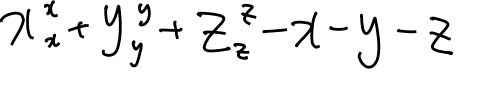

In [43]:
Image.open(dataset.pairs[0][0][1])

In [58]:
np.array(preds[0]).squeeze()

def parse_prediction(pred):
    pred = np.array(pred).squeeze()
    return ''.join(pred)

print(parse_prediction(preds[np.argmax(bleu_list)]))

\sqrt{1+\sqrt{1+\sqrt{1+\sqrt{x}}}}


$\sqrt{1+\sqrt{1+\sqrt{1+\sqrt{x}}}}$

# Test with multiline training

In [4]:
import metrics as perf_evaluation

In [5]:
import importlib
importlib.reload(perf_evaluation)

<module 'metrics' from '/Users/juansegundohevia/Documents/repos/TexTract/metrics.py'>

In [6]:
ml_model, ml_dataset_test, args = perf_evaluation.get_model_and_data(config_path="pix2tex/model/settings/multiline_training.yaml",
                                   checkpoint_path="multiline_checkpoints/local_multiline_pix2text/local_multiline_pix2text_e01_step99.pth",
                                   data_path="pix2tex/dataset/multiline/test_300_resized_dataset.pkl",
                                    temperature=.9, batch_size=1, device="mps")

In [7]:
ml_bleu_score, ml_edit_distance, ml_token_accuracy, ml_bleu_list, ml_edit_dists_list, ml_token_acc_list, ml_preds = perf_evaluation.evaluate(ml_model, ml_dataset_test, args)

BLEU: 0.248, ED: 1.25e+00, ACC: 0.067:   2%|▏         | 7/300 [16:07<10:05:35, 124.01s/it]

## Size error
height and widht of images must be multiples of 32

In [69]:
# check current dimensions
Image.open(ml_dataset_test.images[0]).size

(88, 64)